In [59]:
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

In [41]:
# Load dataset
df = pd.read_csv("disease_diagnosis.csv")

In [42]:
# Convert Blood Pressure to numerical columns
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood_Pressure_mmHg'].str.split('/', expand=True).astype(int)

# Healthy = 0, else = 1
df['Diagnosis'] = np.where(df['Diagnosis'].str.lower() == 'healthy', 0, 1)

# Pulling out relevant features
health_features = ['Age', 'Heart_Rate_bpm', 'Body_Temperature_C', 'Systolic_BP', 'Diastolic_BP']

# Separate features and target
X = df[health_features]
y = df['Diagnosis']

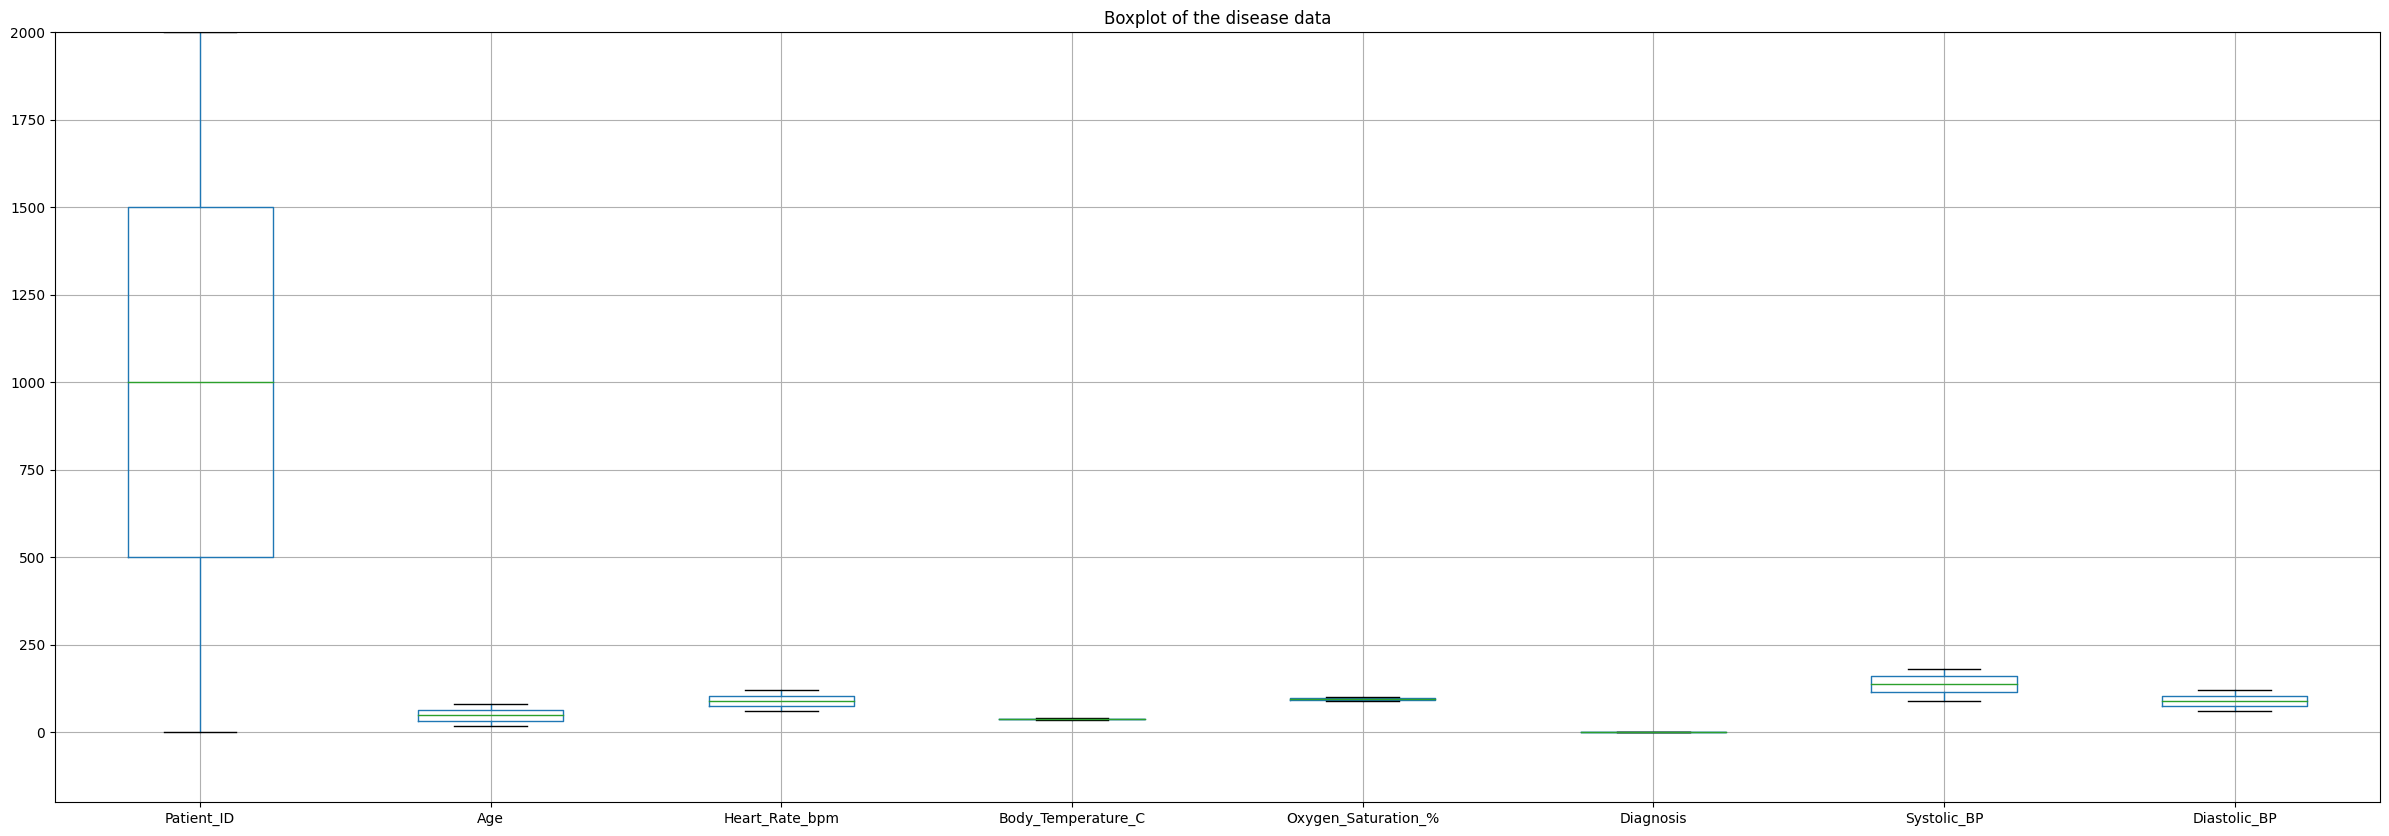

In [43]:
# Sets up the size of the plot
plt.figure(figsize = (30, 10))
# Title and plots the data in boxplots
plt.title("Boxplot of the disease data")
df.boxplot()
# Sets the range of the boxplot. Very large because of high variability
plt.ylim(-200,2000)
# Displays plot
plt.show()

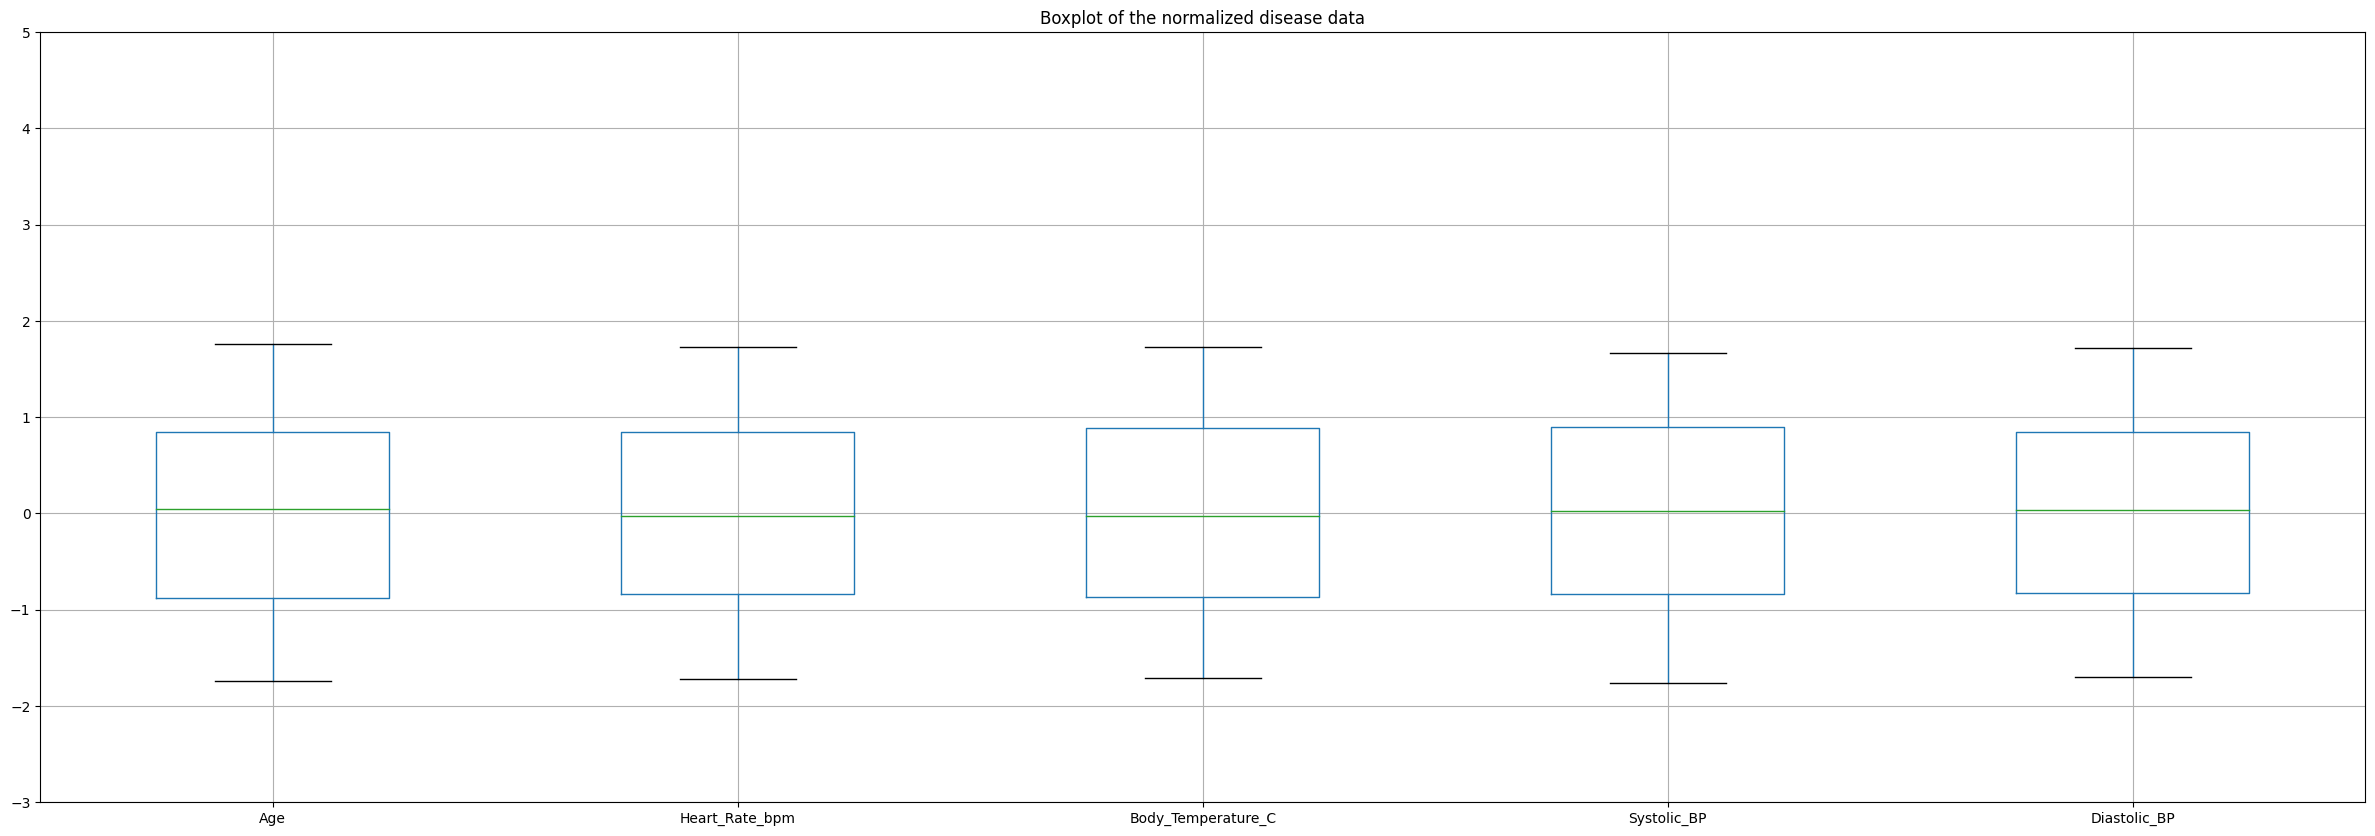

In [44]:
# Standardize features
# Select the columns to standardize
columns_to_standardize = ["Age", "Heart_Rate_bpm", "Body_Temperature_C", "Systolic_BP", "Diastolic_BP"]
df_to_standardize = df[columns_to_standardize]

# Standardize the selected columns
df_standardized = (df_to_standardize - df_to_standardize.mean()) / df_to_standardize.std()

# Combine the standardized columns back with the non-standardized columns
df_non_standardized = df.drop(columns=columns_to_standardize)
df_combined = pd.concat([df_non_standardized, df_standardized], axis=1)

# Create a new DataFrame with the combined data
df = pd.DataFrame(df_standardized)
corr = df.corr()

# Sets up the size of the plot
plt.figure(figsize = (30, 10))
# Title and plots the data in boxplots
plt.title("Boxplot of the normalized disease data")
df.boxplot()
# Sets the range of the boxplot. Very large because of high variability
plt.ylim(-3,5)
# Displays plot
plt.show()

<Axes: >

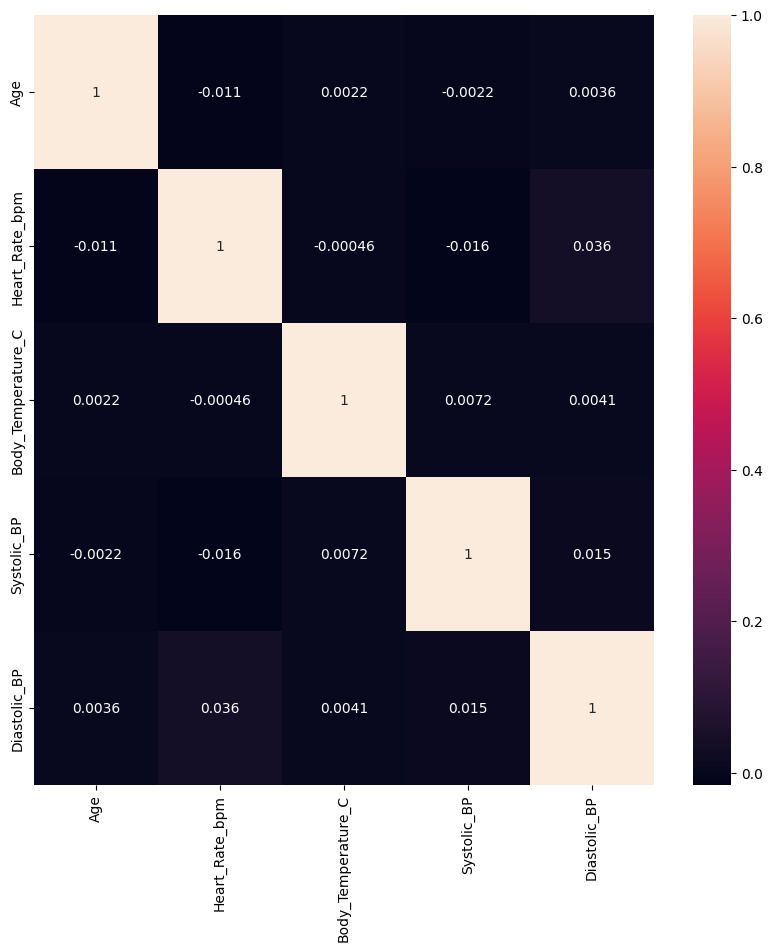

In [45]:
corr = df.corr()

# Visualize correlation matrix
plt.figure(figsize = (10, 10))
# Displays heatmap of the correlation matrix. Made sure to add annotations to the heat nodes
sns.heatmap(corr, annot = True, xticklabels=corr.columns, yticklabels=corr.columns)

In [46]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=42)

In [47]:
# Predict on test data
y_pred = svm_model.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.5825


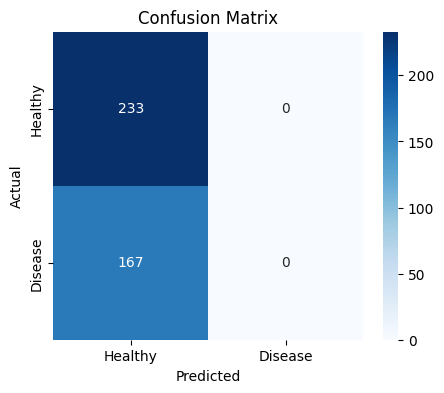

In [48]:
# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Disease'], yticklabels=['Healthy', 'Disease'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [38]:
# Select two features for visualization (Age and Body Temperature)
X_vis = X[['Age', 'Body_Temperature_C']]
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(X_vis, y, test_size=0.2, random_state=42, stratify=y)
scaler_vis = StandardScaler()
X_train_vis_scaled = scaler_vis.fit_transform(X_train_vis)
X_test_vis_scaled = scaler_vis.transform(X_test_vis)
svm_vis_model = SVC(kernel='linear', random_state=42)
svm_vis_model.fit(X_train_vis_scaled, y_train_vis)

SVC(kernel='linear', random_state=42)

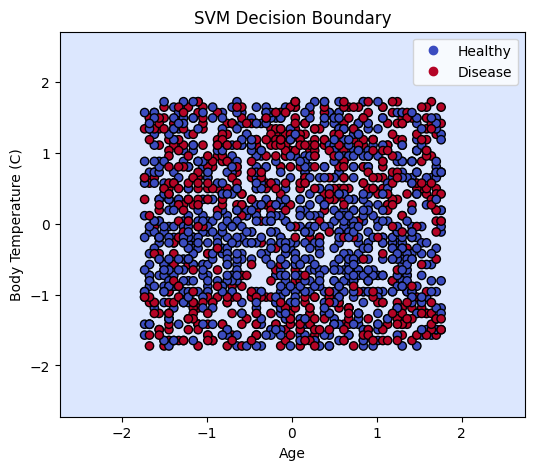

In [39]:
def plot_decision_boundary(X, y, model):
    h = .02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='coolwarm')
    plt.xlabel("Age")
    plt.ylabel("Body Temperature (C)")
    plt.title("SVM Decision Boundary")
    plt.legend(handles=scatter.legend_elements()[0], labels=['Healthy', 'Disease'])
    plt.show()

plot_decision_boundary(X_train_vis_scaled, y_train_vis.to_numpy(), svm_vis_model)



In [51]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=3)
X_selected = selector.fit_transform(X, y)
selected_features = np.array(health_features)[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: ['Heart_Rate_bpm' 'Body_Temperature_C' 'Diastolic_BP']


In [52]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly']
}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'kernel': ['rbf', 'poly']},
             scoring='accuracy')

In [54]:
# Train the best model
best_svm = grid_search.best_estimator_
best_svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=1)

In [60]:
# Predict on test data
y_pred = best_svm.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Best Model Accuracy: {accuracy:.4f}")
print("Classification Report")
print(report)



Best Model Accuracy: 0.6150
Classification Report
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       233
           1       0.54      0.53      0.54       167

    accuracy                           0.61       400
   macro avg       0.60      0.60      0.60       400
weighted avg       0.61      0.61      0.61       400



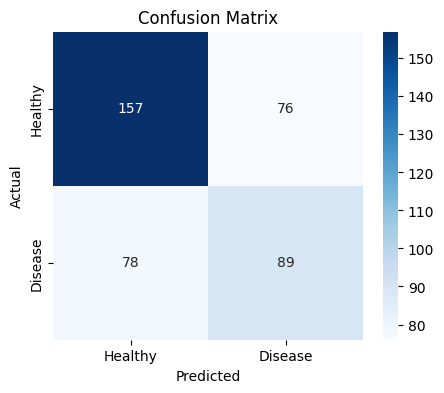

In [56]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Disease'], yticklabels=['Healthy', 'Disease'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
